# Config

In [ ]:
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(parent_dir)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] =  "0"
# from huggingface_hub import interpreter_login; interpreter_login() # id

import gc
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

from utils import Config, Data_Manager, model_selection
from utils_data_generation import OpenAI_Batch_Processor, Setup_Prompts, OpenAI_Async_Processor, Google_Async_Processor, generate_texts, Google_Batch_Processor, extract_activations
from utils_data_eval import linear_fit_torch

import nest_asyncio

cfg = Config()
dm = Data_Manager(cfg)

label_dict, sub_dim_dict, symp_keys, subdim_keys  = dm.load_dict(dict_type='label')
query_dict = dm.load_dict(dict_type='query')
abbv_dict = dm.load_dict(dict_type='abbv')

# Generate, Predict, Update Data

In [ ]:
"""
choose task:
    'generate':     Section A4.2 - Step 1 (generates the text data expressing the labeled thoughts)
    'predict':      Section A4.2 - Step 2 (predicts the text data labels)
    'generate-sev': Section A4.3 - Step 1 (generates the text data expressing varying severity of the labeled thoughts)
    'predict-sev':  Section A4.3 - Step 2 (predicts the text data severity)
"""

task = 'generate' # 'generate' , 'predict' , 'generate-sev' , 'predict-sev'

Step 1&2: Option 1 - Executes async API call (faster option)

In [ ]:
"""
ASYNC PROCESSING
"""

nest_asyncio.apply()

if 'gpt' in cfg.api_model_id.lower(): 
    processor_async = OpenAI_Async_Processor(cfg, label_dict); print(f'Using {cfg.api_model_id} for async processing \n') # 
if 'gemini' in cfg.api_model_id.lower(): 
    processor_async = Google_Async_Processor(cfg, label_dict); print(f'Using {cfg.api_model_id} for async processing \n')
    
chat_system = Setup_Prompts(cfg, label_dict, sub_dim_dict, query_dict)

for t in label_dict.keys():
    print('THOUGHT VAR:', t)
    chats, df = chat_system.setup_prompts(thought_var=t, task=task)
    df = processor_async.process_async(t, task, chats, df)

Step 1&2: Option 2 - Executes batch processing (cheaper option)

In [ ]:
"""
BATCH PROCESSING - API REQUEST
"""

task = 'predict' # 'generate', 'predict', 'generate-sev', 'predict-sev'
chat_system = Setup_Prompts(cfg, label_dict, sub_dim_dict, query_dict)

if 'gpt' in cfg.api_model_id: 
    processor_batch = OpenAI_Batch_Processor(cfg, label_dict)
elif 'gemini' in cfg.api_model_id: 
    processor_batch = Google_Batch_Processor(cfg, label_dict)

for t in label_dict.keys():
    print('THOUGHT VAR:', t)
    chats, df = chat_system.setup_prompts(thought_var=t, task=task)
    batch, chats, df = processor_batch.request_batch(t, task, chats, df)


In [ ]:
"""
BATCH PROCESSING - CHECK STATUS, RETRIEVE, or CANCEL
"""

task = 'generate' # 'generate', 'predict', 'generate-sev', 'predict-sev'

thought_vars = list(all_label_dict.keys())

for t in thought_vars:
    print('THOUGHT VAR:', t)    
    
    if 'gpt' in cfg.api_model_id:
        processor_batch = OpenAI_Batch_Processor(cfg, all_label_dict)
        batch_list = processor_batch.load_batch(t, task)
        json_path = cfg.json_gen_file if task == 'generate' else cfg.json_pred_file
        for batch in batch_list:
            status = cfg.client.batches.retrieve(batch.id).status
            print(f'Batch ID: {batch.id}')
            print(f'Batch request status: {status}')
            print(f'Batch status: {batch.request_counts} \n')

    ### check batch status
    # batch_id = ''
    # cfg.client.batches.retrieve(batch_id)
    # cfg.client.batches.cancel(batch_id)
    
    elif 'gemini' in cfg.api_model_id:    
        processor_batch = Google_Batch_Processor(cfg, all_label_dict)
        batch_list = processor_batch.load_batch(t, task)
        json_path = cfg.json_gen_file if task == 'generate' else cfg.json_pred_file
        for batch in batch_list:
            print(f'Batch ID: {batch.display_name}')
            print(f'Batch request status: {batch.state.name} \n')    
    

In [ ]:
"""
BATCH PROCESSING - TO CSV
"""

task = 'generate' # 'generate', 'predict', 'generate-sev', 'predict-sev'
thought_vars = all_label_dict.keys()
chat_system = Setup_Prompts(cfg, all_label_dict, label_dict, sub_dim_dict, query_dict)

if 'gpt' in cfg.api_model_id:
    processor_batch = OpenAI_Batch_Processor(cfg, all_label_dict)
elif 'gemini' in cfg.api_model_id:
    processor_batch = Google_Batch_Processor(cfg, all_label_dict)

for t in thought_vars:
    print('THOUGHT VAR:', t)
    batch_list = processor_batch.load_batch(t, task)
    data = []
    for batch in batch_list:
        data.extend(processor_batch.check_batch_status_api(batch, task))
    chats, df = chat_system.setup_prompts(thought_var=t, task=task)
    df = processor_batch.batch_to_df(data, df, task)

POST-Process: Steps 3 & 4

In [ ]:
"""
FILTER SAE TRAIN DATA (RUN ONLY AFTER DATA GENERATION IS DONE)
"""

from utils_data_generation import postprocess_data
filt_dfs, _ = postprocess_data(cfg, label_dict, filter_acc_threshold=0.1)

# Extract LLM Activation

In [ ]:
"""
EXTRACT LLM ACTIVATIONS FROM THE FILTERED DATA
"""

df = pd.read_csv(f'{cfg.filt_data_dir}/{cfg.df_file_name}_v{cfg.current_v}.csv')

model, tokenizer = model_selection(cfg)

X_dict, y = extract_activations(
    model, 
    tokenizer,
    dfs=df,
    tf_lib=cfg.tf_lib,
    label_dict=label_dict,
    batch_size=256, 
    layers=cfg.hook_layers,
)

"""
SAVE ACTIVATIONS AND LABELS
"""
for layer in cfg.hook_layers:
    if not os.path.exists(f'{cfg.feat_dir}/layer_{layer}'):
        os.makedirs(f'{cfg.feat_dir}/layer_{layer}')

    X_path = f'{cfg.feat_dir}/layer_{layer}/{cfg.X_file_name}_v{cfg.current_v}.pt'
    y_path = f'{cfg.feat_dir}/layer_{layer}/{cfg.y_file_name}_v{cfg.current_v}.pt'
    std_path = f'{cfg.feat_dir}/layer_{layer}/{cfg.X_file_name}_std_v{cfg.current_v}.pt'

    torch.save(X_dict[layer], X_path)
    torch.save(y, y_path)
    torch.save(X_dict[layer].std(), std_path)

del X_dict, y, model, tokenizer
gc.collect()
torch.cuda.empty_cache()

Extracting activations...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 641/641 [14:53<00:00,  1.39s/it]


Done!


# Eval Data

In [ ]:
"""
EVAL DATA (X->Y FIT)
"""

X_dict, y = dm.load_dict(dict_type='activation')
std_dict = dm.load_dict(dict_type='act-std')
for hook_layer in cfg.hook_layers:
    X = X_dict[hook_layer]
    X = X / std_dict[hook_layer]  # standardize by std
    print('Layer: ',hook_layer)
    print(X.shape); print(y.shape)
    probe = linear_fit_torch(X, y, test_size=0.1, num_epochs = 1000, lr=0.1, device='cuda:0')
    print()

 Total Count of Labels 
                 count
depressed mood   13622
low self-esteem  16294
negative bias    15094
guilt            14652
risk-aversion    17811
self-harm         9188
manic mood        7579
grandiosity      14435
positive bias     7758
lack of remorse   5788
risk-seeking     11104
hostility        11890 

 Ratio of Uniquely Assigned Labels 
                    count
depressed mood   0.802672
low self-esteem  0.580705
negative bias    0.736319
guilt            0.934616
risk-aversion    0.854640
self-harm        0.813888
manic mood       0.557461
grandiosity      0.757049
positive bias    0.904099
lack of remorse  0.969938
risk-seeking     0.894452
hostility        0.922119 

 Co-Occurence Matrix 


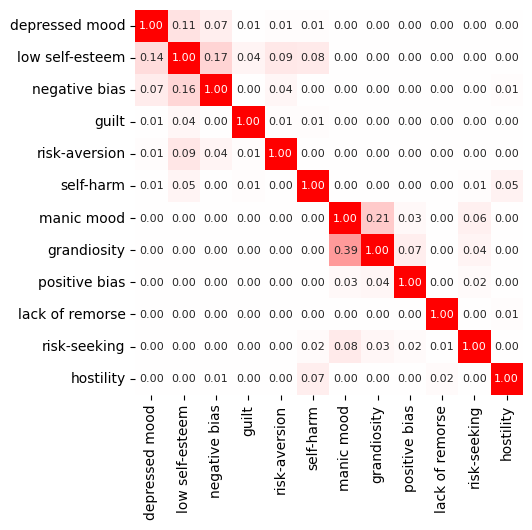

In [17]:
"""
EVAL DATA (LABEL DISTRIBUTION)
"""

y = dm.load_pt('y', cfg.hook_layers[0])
y_np = y.numpy()

# label count for each label
print(f"\033[1m\033[92m Total Count of Labels \033[0m")
label_count = np.sum(y_np, axis=0)
label_count = pd.DataFrame(label_count, index=label_dict.keys(), columns=['count']).astype(int)
label_count = label_count.T[label_dict.keys()].T
label_count.index = [abbv_dict[label] for label in label_count.index]
print(label_count, '\n')


# count non-coocurring labels
print(f"\033[1m\033[92m Ratio of Uniquely Assigned Labels \033[0m")
non_cooccur = np.sum(y_np, axis=1)
idx = np.where(non_cooccur == 1)[0]
unique_labels = y_np[idx].sum(axis=0)
unique_labels = pd.DataFrame(unique_labels, index=label_dict.keys(), columns=['count']).astype(int)
unique_labels = unique_labels.T[label_dict.keys()].T
unique_labels.index = [abbv_dict[label] for label in unique_labels.index]
ratios = unique_labels / label_count
print(ratios, '\n')


# for each label, count co-occurrence with other labels
print(f"\033[1m\033[92m Co-Occurence Matrix \033[0m")
cooccur = np.zeros((len(label_dict), len(label_dict)))
for i in range(len(label_dict)):
    for j in range(len(label_dict)):
        cooccur[i, j] = np.sum(y_np[:, i] * y_np[:, j]) # when label i is present, how often is label j present
        
cooccur = pd.DataFrame(cooccur, index=label_dict.keys(), columns=label_dict.keys())
cooccur_ratio = cooccur / np.sum(y_np, axis=0)
cooccur_ratio = cooccur_ratio.fillna(0)
cooccur_ratio = cooccur_ratio[symp_keys].loc[symp_keys]
plt.figure(figsize=(5, 5))
sns.heatmap(cooccur_ratio, annot=True, fmt=".2f", cmap='bwr', annot_kws={"size": 8}, xticklabels=abbv_dict.values(), yticklabels=abbv_dict.values(), cbar=False, vmin=-1)
plt.title(''); plt.xlabel(''); plt.ylabel('')
# plt.savefig(f'./figs/5e.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()